# Chat Fine-tuning

Quantized Low-Rank Adapter Model Fine-tuning

---

Built by Trelis. Find us on [HuggingFace](https://huggingface.co/Trelis).

This script is commercially licensed and available for purchase per seat/user. [Request access here](https://buy.stripe.com/5kAaFq4pLbe3bQYcNf).

You can also purchase access to the full GitHub Repo, including:
1. Embedding Notebook
2. Fine-tuning Notebook Supervised Learning + Data-prep
3. Fine-tuning Notebook Unsupervised Learning + Data-prep
4. Dataset Preparation
5. Quantization Notebooks (GGUF and AWQ)

[Request access here](https://buy.stripe.com/cN27tef4p2Hx2go4gD). Access will be granted within 24 hours of purchase.


In [1]:
# Required when training models/data that are gated on HuggingFace, and required for pushing models to HuggingFace
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [2]:
cache_dir=''

### Connect Google Drive

Optional but saves time by caching the model and allows for training data to be saved on Drive.

In [3]:
# # https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import os
# cache_dir = "/content/drive/My Drive/huggingface_cache"
# os.makedirs(cache_dir, exist_ok=True) # Ensure the directory exists

# Installation

In [6]:
!python -m pip install --upgrade pip
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install -q -U scipy
!pip install -q -U trl

# Load the Model

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# using a base model here for unsupervised trial.
# model_id = "PY007/TinyLlama-1.1B-intermediate-step-480k-1T"
model_id = "meta-llama/Llama-2-7b-hf"
# model_id = "meta-llama/Llama-2-7b-chat-hf"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # quantization_config=bnb_config, #uncomment for quantized fine-tuning.
    device_map={"":0},
    torch_dtype=torch.bfloat16,
    cache_dir=cache_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Prepare for LoRA fine-tuning

In [8]:
from peft import LoraConfig, get_peft_model

config = LoraConfig( #matching the Llama recipe
    r=8,
    lora_alpha=32,
    target_modules=[
              "self_attn.q_proj",
              "self_attn.k_proj",
              "self_attn.v_proj",
              "self_attn.o_proj",
              # "self_attn.rotary_emb.inv_freq",
              # "mlp.gate_proj",
              # "mlp.up_proj",
              # "mlp.down_proj",
              # "input_layernorm.weight",
              # "post_attention_layernorm.weight",
              # "model.norm.weight",
              # "lm_head.weight"
              ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Set up Tokenizer and Padding

In [9]:
# ## guanaco eos = ### Human [WARNING - THIS APPROACH DOES NOT WORK!!!]

# tokenizer = AutoTokenizer.from_pretrained(model_id,use_fast=True)
# print(tokenizer)

# # Check if '<pad>' is already in the tokenizer vocabulary
# if '<pad>' not in tokenizer.get_vocab():
#   # Add the pad token
#   tokenizer.add_special_tokens({"pad_token": "<pad>"})

# # Add the new EOS token
# added_tokens = tokenizer.add_special_tokens({"eos_token": "###"})

# # Check if the model needs to be resized
# if added_tokens > 0:
#   model.resize_token_embeddings(len(tokenizer))

# # Configure pad token and EOS token in the model
# model.config.pad_token_id = tokenizer.pad_token_id
# model.config.eos_token_id = tokenizer.eos_token_id

# # Assertions to make sure everything is set up correctly
# assert model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"
# assert model.config.eos_token_id == tokenizer.eos_token_id, "The model's EOS token ID does not match the tokenizer's EOS token ID!"

# # Print the token ids for debugging
# print('Tokenizer pad token ID:', tokenizer.pad_token_id)
# print('Tokenizer EOS token ID:', tokenizer.eos_token_id)
# print('Model pad token ID:', model.config.pad_token_id)
# print('Model EOS token ID:', model.config.eos_token_id)

In [10]:
## </s> EOS

tokenizer = AutoTokenizer.from_pretrained(model_id,use_fast=True)
print(tokenizer)

# Check if '<pad>' is already in the tokenizer vocabulary
if '<pad>' not in tokenizer.get_vocab():
    # Add the pad token
    added_tokens = tokenizer.add_special_tokens({"pad_token": "<pad>"})
else:
    added_tokens = 0  # No tokens were added

# Check if the model needs to be resized
if added_tokens > 0:
    model.resize_token_embeddings(len(tokenizer))

# Configure the pad token in the model
model.config.pad_token_id = tokenizer.pad_token_id

# Assertion to make sure everything is set up correctly
assert model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Print the token ids for debugging
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.config.pad_token_id)

# Assertions to make sure everything is set up correctly
assert model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"
assert model.config.eos_token_id == tokenizer.eos_token_id, "The model's EOS token ID does not match the tokenizer's EOS token ID!"

# Print the token ids for debugging
print('Tokenizer EOS token ID:', tokenizer.eos_token_id)
print('Model EOS token ID:', model.config.eos_token_id)

Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


LlamaTokenizerFast(name_or_path='meta-llama/Llama-2-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
Tokenizer pad token ID: 32000
Model pad token ID: 32000
Tokenizer EOS token ID: 2
Model EOS token ID: 2


# Set up Evaluation

In [11]:
from transformers import TextStreamer
from peft import PeftModel
from transformers import StoppingCriteriaList, StoppingCriteria

# Define a stream
def stream(user_prompt, model_type, checkpoint=''):

    if model_type == 'base':
        eval_model = model
    elif model_type == 'fine-tuned':
        eval_model = PeftModel.from_pretrained(model, checkpoint)  # Assuming PeftModel is the intended class
    else:
        print('You must set the model_type to base or fine-tuned')
        exit()  # or raise an exception

    # print(f'Proceeding to inference with peft adapters from {checkpoint}')

    eval_model.config.use_cache = True

    # Llama style
    # system_prompt = 'You are an expert on the rules of touch rugby. You provide very succinct answers no longer than ten words.'
    B_INST, E_INST = "[INST]", "[/INST]"
    prompt = f"{B_INST} {user_prompt.strip()} {E_INST} "

    # # Guanaco style
    # system_prompt = ''
    # B_INST, E_INST = "### Human:", "### Assistant:"
    # prompt = f"{B_INST} {user_prompt.strip()}{E_INST} "

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    streamer = TextStreamer(tokenizer)

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    # _ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=200)
    _ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=200)


def evaluation(model_type, checkpoint=''):
    questions = [
        "What planets are in our solar system?",
        "What are the first five numbers in the Fibonacci series?",
        "Generate a python code snippet to add two numbers."
    ]

    #Optionally provide some correct answers for comparison. This is for manual evaluation. Recommended!
    answers = [
        "",
        "",
        ""
    ]

    for question, answer in zip(questions, answers):
        stream(question, model_type, checkpoint)
        # print("Correct Answer:", answer)
        print('\n\n')

In [12]:
evaluation("base")

<s> [INST] What planets are in our solar system? [/INST] 1. What is the sun? 2. What is the moon? 3. What is a planet? 4. What is a dwarf planet? 5. What is an asteroid? 6. What is a comet? 7. What is a meteorite? 8. What is the solar system? 9. What is the Milky Way galaxy? 10. What is a star? 11. What is a supernova? 12. What is a nebula? 13. What is a constellation? 14. What is a galaxy? 15. What is a black hole? 16. What is a quasar? 17. What is a solar eclipse? 18. What is a lunar eclipse? 19. What is a transit? 20. What is a meteor shower? 21



<s> [INST] What are the first five numbers in the Fibonacci series? [/INST] 2019-04-23 17:08:48
[INST] What are the first five numbers in the Fibonacci series? [/INST]</s>



<s> [INST] Generate a python code snippet to add two numbers. [/INST] 

[INST] Generate a python code snippet to add two numbers. [/INST] 

[INST] Generate a python code snippet to add two numbers. [/INST] 

[INST] Generate a python code snippet to add two numbers. [

# Load the Dataset

In [13]:
## There is truncation, so don't unintentionally use datasets that are larger (unless you update the truncation parameter)!

from datasets import load_dataset

# dataset="Trelis/openassistant-guanaco-EOS"
dataset="Trelis/openassistant-llama-style"
# dataset="timdettmers/openassistant-guanaco"

data = load_dataset(dataset)

In [14]:
# Print first row of 'train' and 'test'
print("First row of train:", data['train'][4])
print("First row of test:", data['test'][0])

First row of train: {'text': '[INST] Método del Perceptrón biclásico: definición y variantes del método. ¿cómo se aplicaría\nal caso multiclásico?, ¿se podría utilizar con patrones que sólo son cuadráticamente\nseparables? [/INST] El método del Perceptrón biclásico es un algoritmo de aprendizaje automático que se utiliza para clasificar patrones en dos categorías. El objetivo del Perceptrón es encontrar un hiperplano que separe las dos clases en el espacio de características.\n\nEn el Perceptrón biclásico, se utilizan los siguientes pasos para entrenar el modelo:\n\n1. Inicializar los pesos con valores aleatorios.\n2. Seleccionar un patrón aleatorio del conjunto de entrenamiento y calcular la salida del Perceptrón.\n3. Actualizar los pesos si la salida del Perceptrón es incorrecta.\n4. Repetir los pasos 2 y 3 hasta que se alcance un criterio de parada.\n\nHay varias variantes del método del Perceptrón biclásico, incluyendo el Perceptrón con margen, el Perceptrón promedio, el Perceptrón

In [15]:
# Extract text from the first row of 'test' in data
text = data['train'][0]['text']

# Tokenize the text
tokens = tokenizer.encode(text, add_special_tokens=True)

# Decode back to text
decoded_text = tokenizer.decode(tokens)

# Print tokens and decoded text
print("Token IDs:", tokens)
print("Decoded Text:", decoded_text)

Token IDs: [1, 518, 25580, 29962, 1815, 366, 2436, 263, 3273, 18707, 1048, 278, 29527, 749, 310, 278, 1840, 376, 3712, 459, 1100, 29891, 29908, 297, 7766, 1199, 29973, 3529, 671, 6455, 4475, 304, 7037, 1601, 459, 1100, 583, 297, 278, 23390, 9999, 322, 274, 568, 8018, 5925, 29889, 518, 29914, 25580, 29962, 376, 7185, 459, 1100, 29891, 29908, 14637, 304, 263, 9999, 3829, 988, 727, 338, 871, 697, 1321, 7598, 363, 263, 3153, 1781, 470, 2669, 29889, 512, 7766, 1199, 29892, 445, 1840, 338, 10734, 8018, 297, 278, 10212, 9999, 29892, 988, 263, 1601, 459, 1100, 29891, 5703, 261, 756, 7282, 3081, 975, 278, 281, 1179, 322, 1985, 5855, 310, 1009, 22873, 29889, 450, 10122, 310, 263, 1601, 459, 1100, 29891, 508, 1121, 297, 5224, 281, 1179, 322, 12212, 5703, 358, 28602, 1907, 363, 17162, 29892, 408, 278, 5703, 261, 756, 2217, 297, 1760, 573, 304, 7910, 281, 1179, 470, 3867, 2253, 1985, 5855, 29889, 13, 13, 4789, 296, 5925, 756, 15659, 7037, 1601, 459, 1100, 583, 297, 6397, 2722, 1316, 408, 3240, 737,

# Train Llama 2!

## Set up and run Training (with saving of data logs to Drive)
Using the TRL trainer is recommended.

In [16]:
import transformers
import os

# Custom callback to log metrics
class LoggingCallback(transformers.TrainerCallback):
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path

    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        with open(self.log_file_path, 'a') as f:
            if 'loss' in logs:
                f.write(f"Step: {state.global_step}, Training Loss: {logs['loss']}\n")
            if 'eval_loss' in logs:
                f.write(f"Step: {state.global_step}, Eval Loss: {logs['eval_loss']}\n")
            f.flush()  # Force flush the buffered data to file

# Log file path
log_file_path = os.path.join(cache_dir, "training_logs.txt")

# Create an instance of the custom callback
logging_callback = LoggingCallback(log_file_path)

### TRL Trainer


In [17]:
epochs=1
context_length = 512
batch_size=1
save_dir = cache_dir + f'/results/{epochs}_epochs_tinyllama_allmodules_{context_length}_length_openassistant-eos'
print(save_dir)

/results/1_epochs_tinyllama_allmodules_512_length_openassistant-eos


In [18]:
from transformers import Trainer
from trl import SFTTrainer

trainer = SFTTrainer(
    peft_config=config,
    dataset_text_field="text",
    max_seq_length=context_length,
    tokenizer=tokenizer,
    model=model,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    args=transformers.TrainingArguments(
        max_steps=60, # comment this out after the first time you run. This is for testing!
        num_train_epochs=epochs,
        output_dir=save_dir,
        evaluation_strategy="steps",
        do_eval=True,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=batch_size,
        log_level="debug",
        optim="paged_adamw_8bit",
        save_steps=0.2,
        logging_steps=1,
        learning_rate=1e-4,
        eval_steps=0.2,
        fp16=True,
        max_grad_norm=0.3,
        warmup_ratio=0.03,
        lr_scheduler_type="linear",
    ),
    callbacks=[logging_callback],  # Add custom callback here
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Currently training with a batch size of: 1
***** Running training *****
  Num examples = 9,846
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60
  Number of trainable parameters = 8,388,608
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
12,1.586800,1.552701
24,1.140400,1.442273
36,1.515900,1.398602
48,1.369300,1.383041
60,1.066200,1.378790


***** Running Evaluation *****
  Num examples = 518
  Batch size = 1
Saving model checkpoint to /results/1_epochs_tinyllama_allmodules_512_length_openassistant-eos/checkpoint-12
tokenizer config file saved in /results/1_epochs_tinyllama_allmodules_512_length_openassistant-eos/checkpoint-12/tokenizer_config.json
Special tokens file saved in /results/1_epochs_tinyllama_allmodules_512_length_openassistant-eos/checkpoint-12/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 518
  Batch size = 1
Saving model checkpoint to /results/1_epochs_tinyllama_allmodules_512_length_openassistant-eos/checkpoint-24
tokenizer config file saved in /results/1_epochs_tinyllama_allmodules_512_length_openassistant-eos/checkpoint-24/tokenizer_config.json
Special tokens file saved in /results/1_epochs_tinyllama_allmodules_512_length_openassistant-eos/checkpoint-24/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 518
  Batch size = 1
Saving model checkpoint to /results

TrainOutput(global_step=60, training_loss=1.4120955874522527, metrics={'train_runtime': 409.503, 'train_samples_per_second': 0.586, 'train_steps_per_second': 0.147, 'total_flos': 3429438930616320.0, 'train_loss': 1.4120955874522527, 'epoch': 0.02})

## Plotting

In [19]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


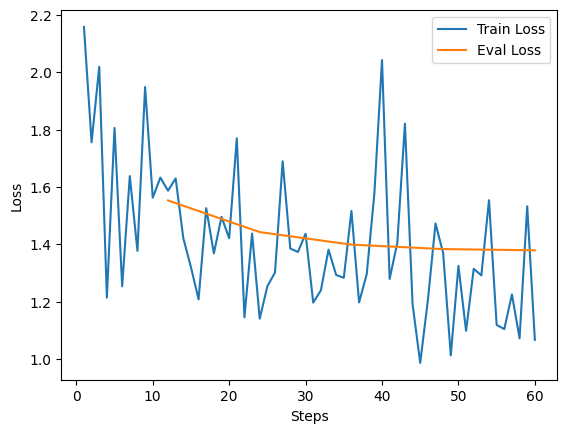

In [20]:
import matplotlib.pyplot as plt

# Initialize lists to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

# Populate the lists from the log history
for entry in trainer.state.log_history:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Plot the losses
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate after Training

In [21]:
checkpoint = save_dir + '/checkpoint-24'
evaluation("fine-tuned", checkpoint)

<s> [INST] What planets are in our solar system? [/INST] 1. How many planets are in our solar system? 2. What is the name of the closest planet to the sun? 3. What is the name of the farthest planet from the sun? 4. What is the name of the planet that has the most moons? 5. What is the name of the planet that is the smallest? 6. What is the name of the planet that is the biggest? 7. What is the name of the planet that is the hottest? 8. What is the name of the planet that is the coldest? 9. What is the name of the planet that has the most volcanoes? 10. What is the name of the planet that has the most earthquakes? 11. What is the name of the planet that has the most tectonic plates? 12. What is the name of the planet that has the most mountains? 



<s> [INST] What are the first five numbers in the Fibonacci series? [/INST] 0, 1, 1, 2, 3</s>



<s> [INST] Generate a python code snippet to add two numbers. [/INST] 1. Create a function called `add_two_numbers` that takes two numbers as i

In [22]:
checkpoint = save_dir + '/checkpoint-48'
evaluation("fine-tuned", checkpoint)

<s> [INST] What planets are in our solar system? [/INST] 1. The Sun. 2. Mercury. 3. Venus. 4. Earth. 5. Mars. 6. Jupiter. 7. Saturn. 8. Uranus. 9. Neptune.</s>



<s> [INST] What are the first five numbers in the Fibonacci series? [/INST] 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 92



<s> [INST] Generate a python code snippet to add two numbers. [/INST] 
```python
def add_two_numbers(x, y):
   return x + y
```


</s>





In [23]:
checkpoint = save_dir + '/checkpoint-60'
evaluation("fine-tuned", checkpoint)

<s> [INST] What planets are in our solar system? [/INST] 1. The Sun 2. Mercury 3. Venus 4. Earth 5. Mars 6. Jupiter 7. Saturn 8. Uranus 9. Neptune</s>



<s> [INST] What are the first five numbers in the Fibonacci series? [/INST] 1, 1, 2, 3, 5</s>



<s> [INST] Generate a python code snippet to add two numbers. [/INST] 

```python
def add(a, b):
   return a + b
```</s>





# Merge Adapters and Save Model to Hub

In [ ]:
# from peft import PeftModel

# adapter_to_push = save_dir + '/checkpoint-48'

# # load perf model with new adapters
# model_to_push = PeftModel.from_pretrained(
#     model,
#     adapter_to_push,
# )

In [ ]:
# # Extract the last portion of the base_model
# model_id = model_id.split("/")[-1]
# fine_tuned_tag = 'chat-llama-style'

# # Define the save and push paths
# adapter_model = f"Trelis/{model_id}-{fine_tuned_tag}-adapters"
# new_model = f"Trelis/{model_id}-{fine_tuned_tag}" #adjust 'Trelis' to your HuggingFace organisation

In [ ]:
# # Save the model
# model_to_push.save_pretrained(adapter_model, push_to_hub=True, use_auth_token=True)

# # Push the model to the hub
# model_to_push.push_to_hub(adapter_model, use_auth_token=True)

In [ ]:
# # from transformers import AutoModelForCausalLM, PretrainedConfig
# # import torch

# # reload the base model (you might need a pro subscription for this because you may need a high RAM environment since this is loading the full original model, not quantized)
# model = AutoModelForCausalLM.from_pretrained(
#     base_model,
#     quantization_config=bnb_config, # important to merge to the quantized version, otherwise there's small error
#     device_map='cpu',
#     trust_remote_code=True,
#     torch_dtype=torch.float16,
#     cache_dir=cache_dir)

In [ ]:
# model_to_push = model_to_push.merge_and_unload() # merge adapters with the base model.

In [ ]:
# model_to_push.push_to_hub(new_model, use_auth_token=True, max_shard_size="10GB", use_safetensors=True)

In [ ]:
# #Push the tokenizer
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# tokenizer.push_to_hub(new_model, use_auth_token=True)